In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# have a dataset for training and distinct dataset for testing
prices_dataset_training = pd.read_csv("/content/drive/MyDrive/SP500_train.csv")
prices_dataset_test = pd.read_csv("/content/drive/MyDrive/SP500_test.csv")

In [ ]:
# we are after a given column in the dataset
# We are going to use adj close price.
trainingset = prices_dataset_training.iloc[:, 5:6].values
testset = prices_dataset_test.iloc[:,5:6].values

In [ ]:
print(prices_dataset_test.shape)
print(prices_dataset_training.shape)
print(trainingset.shape)
print(testset.shape)

(20, 7)
(1258, 7)
(1258, 1)
(20, 1)


In [ ]:
# Use min-max normalization to normalize the dataset
min_max_scaler = MinMaxScaler(feature_range=(0,1))
scaled_trainingset = min_max_scaler.fit_transform(trainingset)

In [ ]:
print(scaled_trainingset)

[[0.00000000e+00]
 [2.41278448e-04]
 [4.02147503e-03]
 ...
 [9.78082912e-01]
 [9.77419457e-01]
 [9.66933529e-01]]


In [ ]:
# create the training dataset because the features are the previous values
# So we have n previous values : and we predict the next value in the time series
X_train = []
y_train = []

In [ ]:
for i in range(40, 1258):
  # 0 is the column index because we have a single column
  # we use the previous 40 prices in order to forecast the next one
  X_train.append(scaled_trainingset[i-40:i,0])
  # indexes start with 0 so this is the target(the price for tmr)
  y_train.append(scaled_trainingset[i,0])

In [ ]:
# we want to handle np array
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# Input shape for LSTM architecture
# we have to reshape the dataset (numOfSamples, numOfFeatures, 1)
# we have 1 because we want to predict the price for tmr (so 1 value)
# numOfFeature : the past prices we uese as features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
#------------- Build LSTM Model ------------------

In [ ]:
# let's build the model
# return sequence ture because we have another LSTM after this one
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.5))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=100))
model.add(Dropout(0.3))
model.add(Dense(units=1))

In [ ]:
# RMSProp is working fine with LSTM but so do ADAM optimizer
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
39/39 [==============================] - 24s 92ms/step - loss: 0.0948
Epoch 2/100
39/39 [==============================] - 4s 91ms/step - loss: 0.0080
Epoch 3/100
39/39 [==============================] - 4s 90ms/step - loss: 0.0054
Epoch 4/100
39/39 [==============================] - 4s 90ms/step - loss: 0.0061
Epoch 5/100
39/39 [==============================] - 4s 91ms/step - loss: 0.0042
Epoch 6/100
39/39 [==============================] - 4s 91ms/step - loss: 0.0053
Epoch 7/100
39/39 [==============================] - 4s 92ms/step - loss: 0.0043
Epoch 8/100
39/39 [==============================] - 4s 92ms/step - loss: 0.0041
Epoch 9/100
39/39 [==============================] - 4s 91ms/step - loss: 0.0049
Epoch 10/100
39/39 [==============================] - 4s 91ms/step - loss: 0.0041
Epoch 11/100
39/39 [==============================] - 4s 91ms/step - loss: 0.0041
Epoch 12/100
39/39 [==============================] - 4s 92ms/step - loss: 0.0039
Epoch 13/100
39/39 [====

In [ ]:
#------------- Testing the Model ------------------

In [ ]:
#training set plus testset
dataset_total = pd.concat((prices_dataset_training['adj_close'],prices_dataset_test['adj_close']), axis=0) 
#vertical axis=0 horizontal axis=1
#all inputs for test set
inputs = dataset_total[len(dataset_total)-len(prices_dataset_test)-40:].values
inputs = inputs.reshape(-1,1)

In [ ]:
#neural net trained on the scaled values we have to min-max normalize the inputs
#it is already fitted so we can use transform directly
inputs = min_max_scaler.transform(inputs) 

In [ ]:
X_test = []

for i in range(40,len(prices_dataset_test)+40):
    X_test.append(inputs[i-40:i,0])

In [ ]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [ ]:
predictions = model.predict(X_test)

print(predictions)

[[0.9657385 ]
 [0.96446115]
 [0.9690866 ]
 [0.97551787]
 [0.98239535]
 [0.985766  ]
 [0.98600185]
 [0.9858506 ]
 [0.9848877 ]
 [0.98471844]
 [0.9838705 ]
 [0.9836756 ]
 [0.98236966]
 [0.9822798 ]
 [0.9818279 ]
 [0.9842399 ]
 [0.9915486 ]
 [0.9993915 ]
 [1.0046159 ]
 [1.0038881 ]]


In [ ]:
#inverse the predicitons because we applied normalization but we want to compare with the original prices
predictions = min_max_scaler.inverse_transform(predictions)
print(predictions)

[[2237.6414]
 [2236.3708]
 [2240.9717]
 [2247.3687]
 [2254.2092]
 [2257.5618]
 [2257.7966]
 [2257.646 ]
 [2256.6885]
 [2256.52  ]
 [2255.6765]
 [2255.483 ]
 [2254.1838]
 [2254.0942]
 [2253.645 ]
 [2256.044 ]
 [2263.3135]
 [2271.1147]
 [2276.3113]
 [2275.5874]]


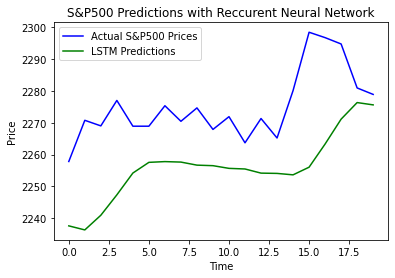

In [ ]:
#plotting the results
plt.plot(testset, color='blue', label='Actual S&P500 Prices')
plt.plot(predictions, color='green', label='LSTM Predictions')
plt.title('S&P500 Predictions with Reccurent Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
print(predictions)

[[2237.6414]
 [2236.3708]
 [2240.9717]
 [2247.3687]
 [2254.2092]
 [2257.5618]
 [2257.7966]
 [2257.646 ]
 [2256.6885]
 [2256.52  ]
 [2255.6765]
 [2255.483 ]
 [2254.1838]
 [2254.0942]
 [2253.645 ]
 [2256.044 ]
 [2263.3135]
 [2271.1147]
 [2276.3113]
 [2275.5874]]
